# Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification


This notebook shows an example for a **arbitrary batch image gradient inversion** as described in "Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification". The setting is a pretrained ResNet-18 and the federated learning algorithm is **fedSGD** in a **cross-silo** setting.

Paper URL: https://arxiv.org/abs/2202.00580

This variant fishes for user data of a single target user by refining an estimate of the user's data distribution over a series of queries. The attacker constructs a binary tree over successive queries until a single data point from the user side is successfully isolated. On average, this should take $\log(n)$ queries for users with $n$ data points from the class that is currently attacked.

#### Abstract
Federated learning (FL) has rapidly risen in popularity due to its promise of privacy and efficiency. Previous works have exposed privacy vulnerabilities in the FL pipeline by recovering user data from gradient updates. However, existing attacks fail to address realistic settings because they either 1) require a `toy' settings with very small batch sizes, or 2) require unrealistic and conspicuous architecture modifications. We introduce a new strategy that dramatically elevates existing attacks to operate on batches of arbitrarily large size, and without architectural modifications. Our model-agnostic strategy only requires modifications to the model parameters sent to the user, which is a realistic threat model in many scenarios. We demonstrate the strategy in challenging large-scale settings, obtaining high-fidelity data extraction in both cross-device and cross-silo federated learning.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case/server=malicious-fishing", "attack=clsattack", "case/user=multiuser_aggregate"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.user.user_range = [0, 1]

cfg.case.data.partition = "random" # This is the average case
cfg.case.user.num_data_points = 256
cfg.case.data.default_clients = 32

cfg.case.user.provide_labels = True # Mostly out of convenience
cfg.case.server.target_cls_idx = 0 # Which class to attack?

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture ResNet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of       0:1 for target shape [256, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 256

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
    Number of aggregated users: 1
Server (of type MaliciousClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation,

### Simulate an attacked FL protocol

This attack runs a modified server protocol, which is able to query the user multiple times. We record the number of queries and later return it from the user.

In [5]:
[shared_data], [server_payload], true_user_data = server.run_protocol(user)

Computing user update on user 0 in model mode: eval.
Found labels [  0   2   5   7   8  10  13  14  16  16  18  19  22  22  22  23  24  25
  27  27  29  30  31  35  36  37  37  37  39  40  43  48  50  51  53  54
  56  58  58  61  63  63  65  66  66  66  69  72  73  73  76  77  78  78
  81  86  87  90  90  91  91  91  94  96  97  98  98  99  99  99  99 101
 101 102 103 103 103 104 104 105 108 110 114 114 115 116 117 119 121 122
 123 124 125 127 128 128 129 129 133 133 134 134 134 135 140 141 143 146
 146 149 149 150 152 154 157 160 160 162 162 163 163 165 169 172 173 173
 174 180 182 182 184 184 186 190 190 191 191 192 192 196 197 199 200 203
 203 204 205 206 212 213 215 215 217 217 218 223 223 227 230 235 236 237
 237 239 240 240 242 242 243 243 245 249 249 250 250 255 255 258 259 260
 261 264 266 267 269 269 270 270 272 272 276 276 279 280 286 286 286 286
 290 290 300 302 303 306 308 308 308 311 312 313 318 319 320 321 322 322
 327 329 331 333 335 337 337 338 339 341 342 346 347 348 3

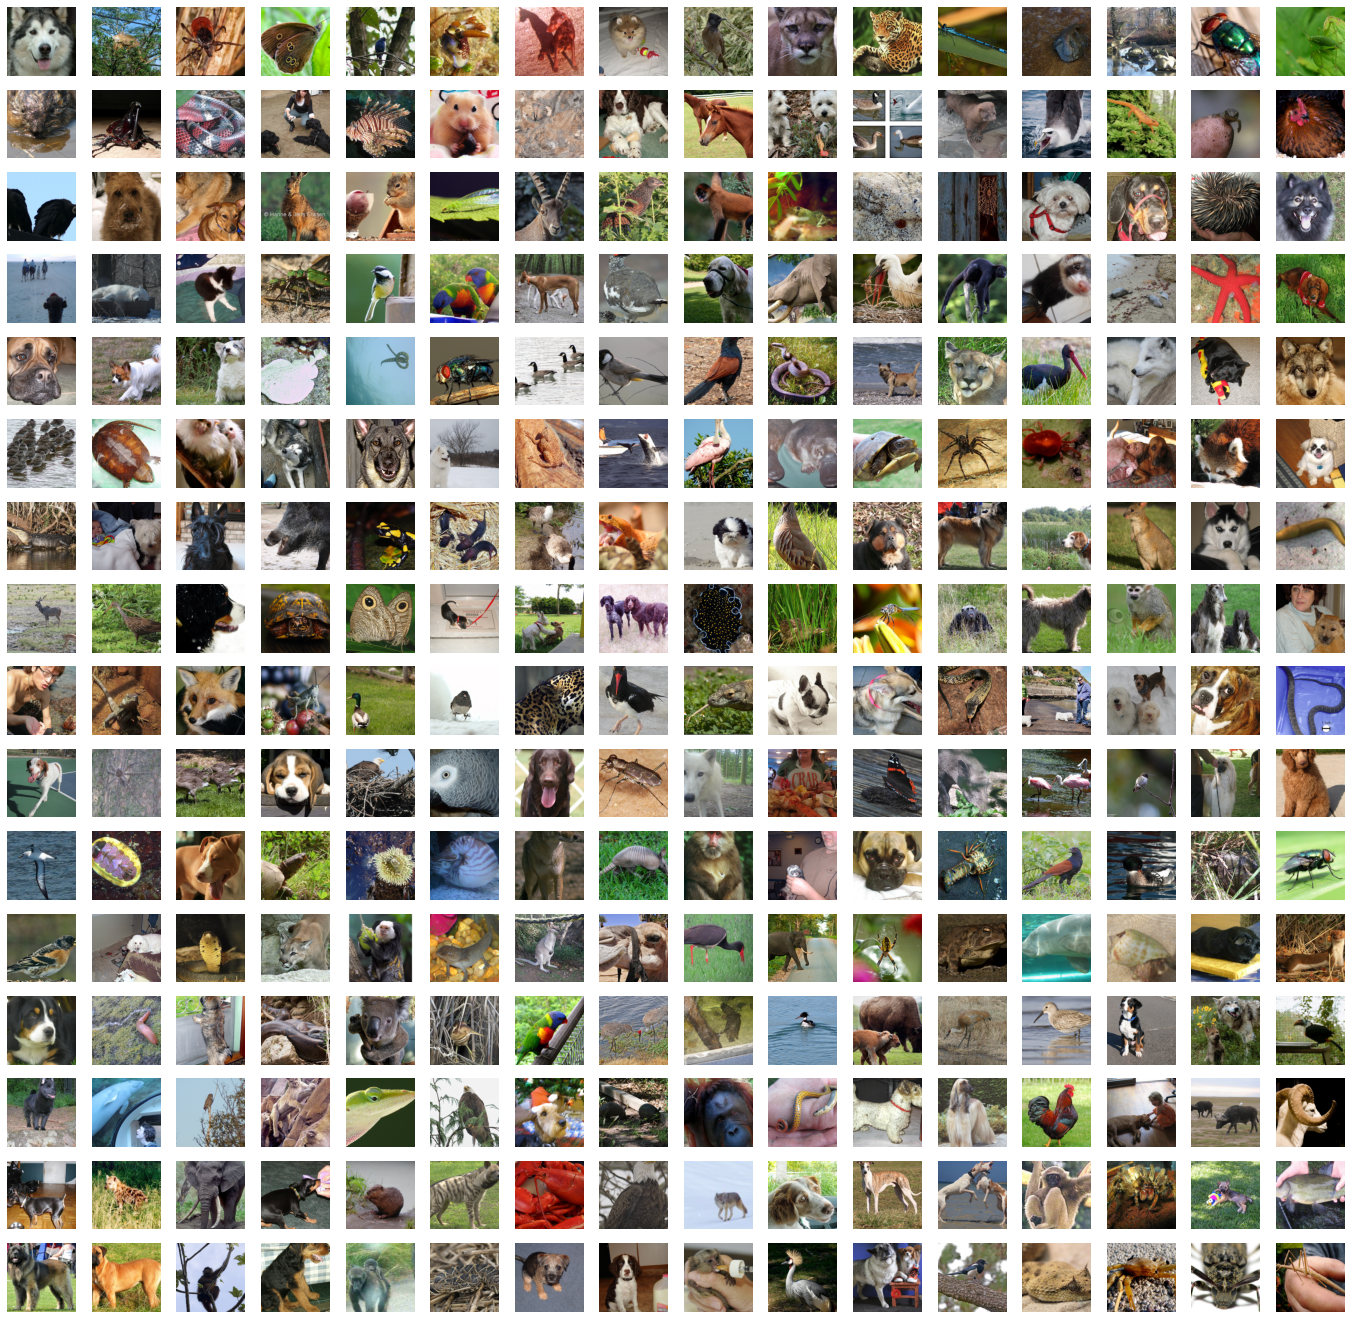

In [6]:
user.plot(true_user_data)

### Now reconstruct  the single "fished" user data point:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution. This reconstruction does not always work, but is at least as powerful as the basic attack (here an optimization-based Inverting Gradients variant) applied to a single data point.

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.3725 |  Task loss: 906.7977 | T: 0.32s
| It: 1001 | Rec. loss: 0.2872 |  Task loss: 627.9431 | T: 44.86s
| It: 2001 | Rec. loss: 0.2354 |  Task loss: 697.8921 | T: 35.46s
| It: 3001 | Rec. loss: 0.2156 |  Task loss: 701.3434 | T: 35.44s
| It: 4001 | Rec. loss: 0.2059 |  Task loss: 698.1614 | T: 35.66s
| It: 5001 | Rec. loss: 0.1908 |  Task loss: 688.6198 | T: 35.44s
| It: 6001 | Rec. loss: 0.1925 |  Task loss: 703.3659 | T: 34.96s
| It: 7001 | Rec. loss: 0.1798 |  Task loss: 678.2094 | T: 35.38s
| It: 8001 | Rec. loss: 0.2036 |  Task loss: 691.1932 | T: 35.29s
| It: 9001 | Rec. loss: 0.1614 |  Task loss: 708.3864 | T: 35.36s
| It: 10001 | Rec. loss: 0.1842 |  Task loss: 693.3807 | T: 35.05s
| It: 11001 | Rec. loss: 0.1554 |  Task loss: 711.3992 | T: 35.39s
| It: 12001 | Rec. loss: 0.1786 |  Task loss: 719.5245 | T: 34.56s
| It: 13001 | Rec. loss: 0.1378 |  Task loss: 705.2759 | T: 32.97s
| It: 14001 | Rec. loss: 0.1333 |  Task loss: 705.7383 | T: 33.15s
| It: 150

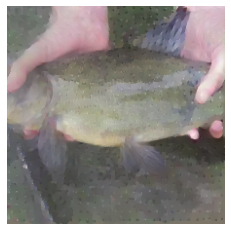

In [9]:
fished_data = dict(data=reconstructed_user_data["data"][server.secrets["ClassAttack"]["target_indx"]], 
                   labels=None)
user.plot(fished_data)

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

First, identify which GT image this is (This saves us from computing metrics for the entire batch):

In [22]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0606 | PSNR: 12.62 | FMSE: 1.5333e+02 | LPIPS: 0.92|
 R-PSNR: 13.16 | IIP-pixel: 2.34% | SSIM: 0.0071 | max R-PSNR: 19.56 | max SSIM: 0.5137 | Label Acc: 100.00%


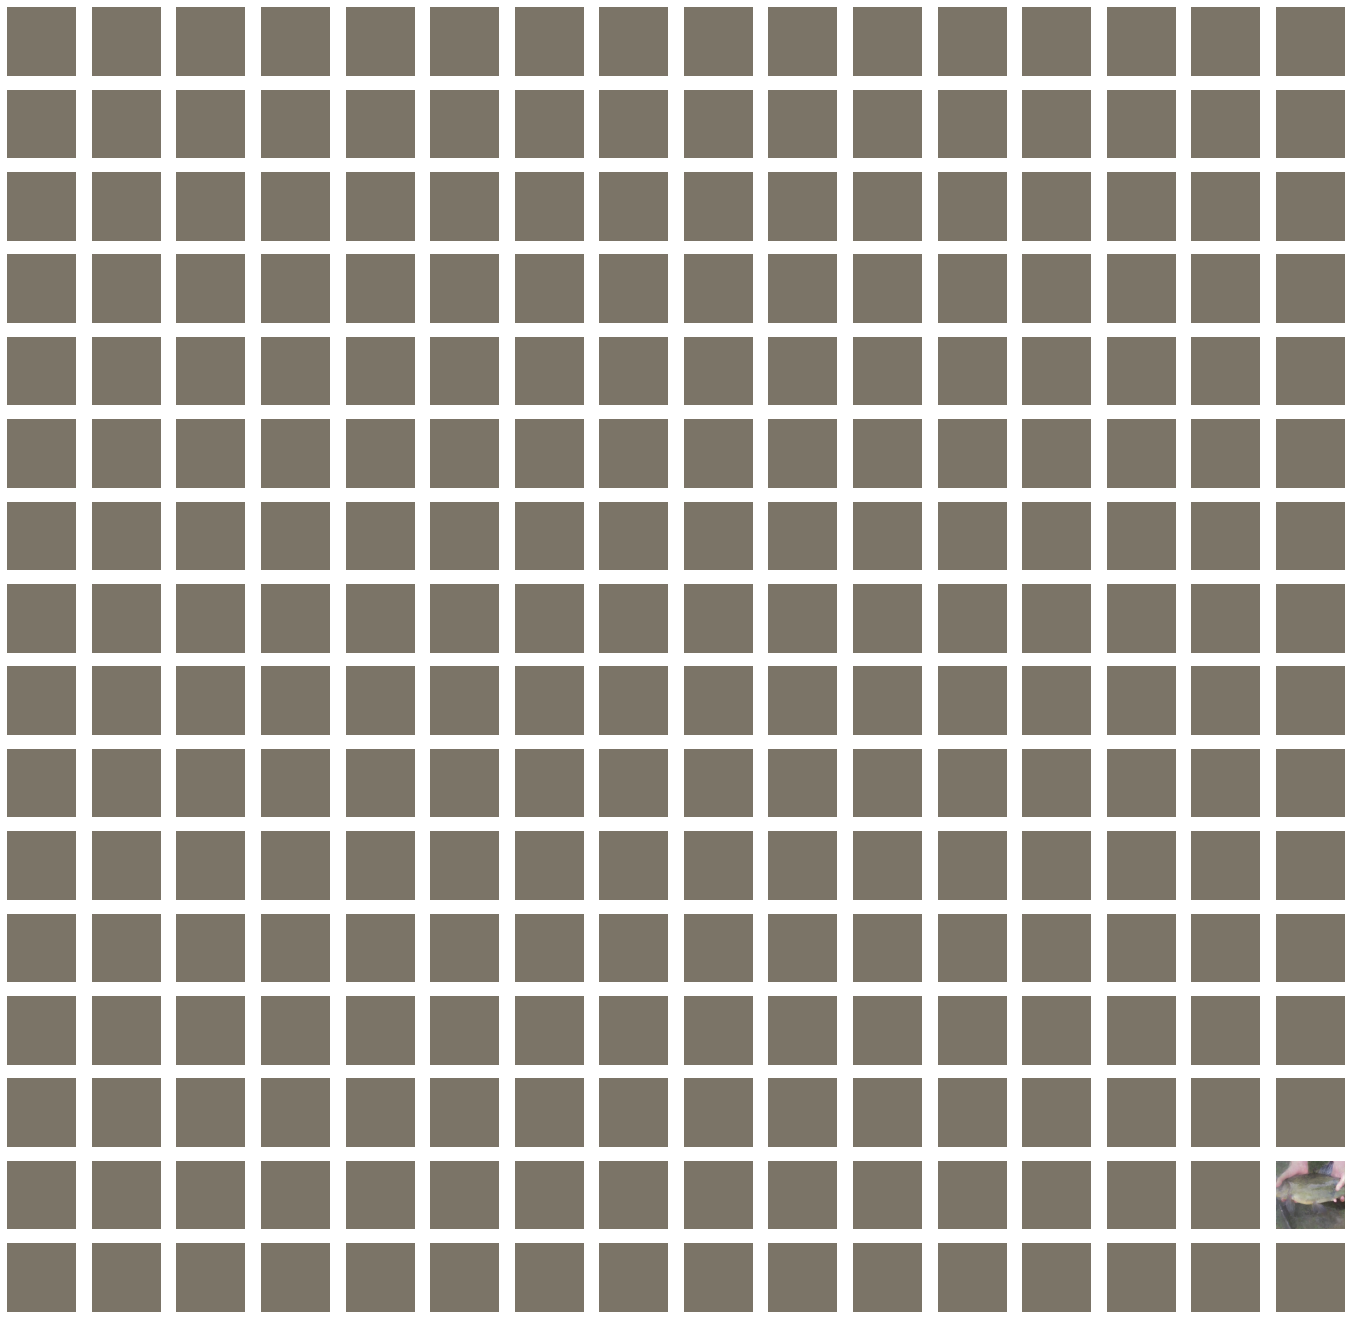

In [23]:
user.plot(reconstructed_user_data)

#### Which gradient is non-trivial

In [ ]:
# from breaching.cases.malicious_modifications.classattack_utils import print_gradients_norm, cal_single_gradients
# single_gradients, single_losses = cal_single_gradients(user.model, loss_fn, true_user_data, setup=setup)
# print_gradients_norm(single_gradients, single_losses)

### Notes:
* You can use `cal_single_gradients` and `print_gradients_norm` from `malicious_modifications.classattack_utils` to verify that only one of the user data points has a non-neglible gradient norm
* Could probably optimize hyperparameters longer to find a more convincing example. The base attack is letting us down a bit with this goldfish example.